## CORDIC To POLE Testbench

This notebook is to test the implementation of a CORDIC running on the programmable logic. The CORDIC is used to convert cartesian to polar coordinates. The output is compared with a Python calculation of the coordinate transform. It takes in x and y and gives out r and theta where r is the radius and theta is the angle.

In [ ]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

In [ ]:
ol=Overlay('../overlay/Cordic1.bit')      #Change name of bitstream as required
cordic_ip=MMIO(0x40000000,10000) #Change base address as required
NUM_SAMPLES = 50
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

In [ ]:
def ConvAndCal(x,y):

    #Converting input to bytes to be sent to FPGA
    x=(struct.unpack('<I', struct.pack('<f', x))[0])
    y=(struct.unpack('<I', struct.pack('<f', y))[0])

    #Writing values to the FPGA
    cordic_ip.write(0x10,x)                             #Change the offset as mentioned in vivado file
    cordic_ip.write(0x18,y)                             #Change the offset as mentioned in vivado file

    #Starting and stopping the IP (Don't change this)
    cordic_ip_ctrl=MMIO(0x40010000,10000)
    cordic_ip_ctrl.write(0x00,1)
    cordic_ip_ctrl.write(0x00,0)

    #Reading from IP
    r=hex(cordic_ip.read(0x20))                         #Change the offset as mentioned in vivado file
    r=r[2:]
    theta=hex(cordic_ip.read(0x30))                     #Change the offset as mentioned in vivado file
    theta=theta[2:]

    #Converting to float
    if r!=0:
        r=struct.unpack('>f', binascii.unhexlify(r))
        r=r[0]
    if theta!=0:
        theta=struct.unpack('>f', binascii.unhexlify(theta))
        theta=theta[0]
    return r,theta

for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    r, theta = ConvAndCal(x,y)
    print("X: ",x,"Y:",y,"\nR:",r,"Theta:",theta,'\n========')
    #Comparing with golden output   
    cn=complex(x,y)
    cn=cmath.polar(cn)
    r_error[i]="{0:.6f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.6f}".format(abs(theta-cn[1]))

## Verifying Functionality

In [ ]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("===>PASS")
else:
    print("===>FAIL")

## Displaying Errors

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

# Interact Playground

FloatSlider(value=0.0, continuous_update=False, description='X:', max=1.0, min=-1.0, readout_format='.3f', ste…

FloatSlider(value=0.0, continuous_update=False, description='Y:', max=1.0, min=-1.0, readout_format='.3f', ste…

Button(description='Compute', style=ButtonStyle(), tooltip='this is a button')

FPGA Accelerator computing with (X,Y) = (0.506450,-0.525810).
Finished Computing with result (R,Theta) = (0.729742,-0.804149).


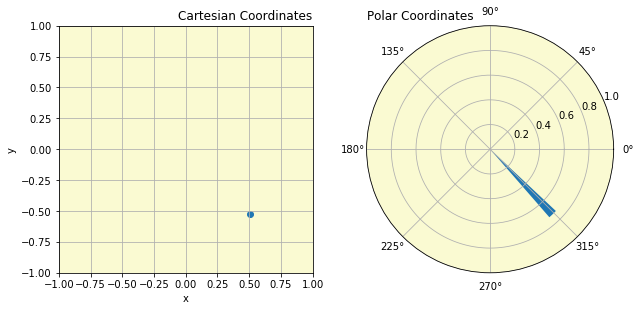

In [33]:
from ipywidgets import widgets

btn = widgets.Button(description = "Compute", tooltip = 'this is a button')
sld1,sld2 = widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.00001,
    description='X:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
),\
widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.00001,
    description='Y:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
def draw(x,y,r,theta):
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(221, facecolor="lightgoldenrodyellow")
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.grid()
    plt.title('Cartesian Coordinates',loc='right')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(x,y,alpha=1)
    ax=plt.subplot(222,projection = 'polar', facecolor="lightgoldenrodyellow")
    ax.set_thetamin(0.0)
    ax.set_thetamax(360.0)
    ax.set_rlim(0.0,1)
    plt.title('Polar Coordinates',loc='left')
    bars=ax.bar(theta,r,width=0.1,bottom=0)
    
def btn_click(sender):
    print('FPGA Accelerator computing with (X,Y) = (%f,%f).' %(sld1.value,sld2.value))
    x=sld1.value
    y=sld2.value
    r,theta = ConvAndCal(x,y)
    print('Finished Computing with result (R,Theta) = (%f,%f).' %(r,theta))
    draw(x,y,r,theta)

cal=btn.on_click(btn_click)
display(sld1,sld2,btn)